In [57]:
#---tensorflow
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
import tensorflow as tf
from tensorflow.keras.models import load_model
#---sklearn
from sklearn.metrics import classification_report
#---others
from cancer_model.cancernet import CancerNet
from imutils import paths
import imutils 
import random
import cv2
import shutil
import os
import matplotlib.pyplot as plt
import splitfolders
import numpy as np

#### Check some pictures

In [4]:
main_path = "....tf_data\\cancer_data\\"
all_images = list(paths.list_images(main_path))

In [5]:
random_images = random.choices(all_images, k=3)
for i in random_images:
    random_image = cv2.imread(i)
    random_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
    random_image = imutils.resize(random_image, height=200)
    cv2.imshow("example", random_image)
    cv2.waitKey(0)
cv2.destroyAllWindows()

##### Divide the data in train, test and validation (easier than train_test_split and goes easy on disk)

In [6]:
random.shuffle(all_images)

In [7]:
#train and test
i = int(len(all_images)*0.8) #80% of data to training set
trainData = all_images[:i]
testData = all_images[i:]

In [8]:
#validation
i = int(len(trainData)*0.1)
validData = trainData[:i]
trainData = trainData[i:]

```another option is to use the splitfolders library which divides the data in training, validation and test on folders on disk. But this only applies when we have all data together in one folder```

#### Extract labels and images and save them on folders

In [9]:
#---Folders
train_path = main_path+"trainig"
valid_path = main_path+"validation"
test_path = main_path+"test"

In [30]:
datasets = [("training", trainData, train_path ), ("validation", validData, valid_path), 
            ("testing", testData, test_path)]

In [42]:
for (dtype, imagepaths, out_path) in datasets:
    if not os.path.exists(out_path):
        os.makedirs(out_path)

    for inputpath in imagepaths:
        filename = inputpath.split(os.path.sep)[-1]
        label = inputpath.split(os.path.sep)[-2] #os.path.sep refers to the "\\"symbols.So split by this.
    
        #Now that we have the labels, create a path with those labels for each dataset
        labelPath = os.path.sep.join([out_path, label])

        if not os.path.exists(labelPath):
            os.makedirs(labelPath)

        #get the image and copy it to the respecive label folder
        p = os.path.sep.join([labelPath, filename])
        shutil.copy2(inputpath, p)        

### Deploy tf.data() pipeline

In [10]:
#---------First! create the preprocess pipeline
def load_images(imagePath):
    #--images
    image = tf.io.read_file(imagePath)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, dtype= tf.float32)
    image = tf.image.resize(image, (48,48))
    #--labels
    label = tf.strings.split(imagePath, os.path.sep)[-2]
    label = tf.strings.to_number(label, tf.int32)
    return(image, label)

In [11]:
@tf.function #the decorator makes this function able to be used with tf on the pipeline
#-------Second! the augmentation pipeline
def augment(image, label):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_flip_left_right(image)
    return(image, label)

In [45]:
#quickly get the images from each path
trainPaths = list(paths.list_images(train_path))
valPaths = list(paths.list_images(valid_path))
testPaths = list(paths.list_images(test_path))

In [46]:
#Construct the tf.data() pipeline for each dataset

#--Train
trainDS = tf.data.Dataset.from_tensor_slices(trainPaths)
trainDS = (trainDS.shuffle(len(trainPaths)).map(load_images, num_parallel_calls=AUTOTUNE)
          .map(augment, num_parallel_calls=AUTOTUNE).cache().batch(64).prefetch(AUTOTUNE)
          )

#--Validation
valDS = tf.data.Dataset.from_tensor_slices(valPaths)
valDS = (valDS.map(load_images, num_parallel_calls=AUTOTUNE).cache().batch(64).prefetch(AUTOTUNE))
#Remember not to shuffle and augment the validation and test, but as always we have to preprocess it

#--Test
testDS = tf.data.Dataset.from_tensor_slices(testPaths)
testDS = (testDS.map(load_images, num_parallel_calls=AUTOTUNE).cache().batch(64).prefetch(AUTOTUNE))

#### Deal with the class imabalance

In [47]:
#Get the labels from the training set
train_paths = list(paths.list_images(train_path))
trainlabels = [int(p.split(os.path.sep)[-2]) for p in train_paths]
#turn them into categorical values so we can count them (one hot encoding)
trainlabels = to_categorical(trainlabels)
classTotals = trainlabels.sum(axis=0)
classWeight = {}
#loop though all the sum and calculate the weights
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max()/classTotals[i]

In [48]:
classWeight

{0: 1.0, 1: 2.5295885}

##### Initialize the model

In [50]:
# initialize our CancerNet model and compile it
model = CancerNet.build(width=48, height=48, depth=3, classes=1)
opt = Adagrad(learning_rate=1e-2, decay=1e-2/40)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

#### Before fit, define some callbacks

In [51]:
early_s = EarlyStopping(monitor="val_loss", patience = 10, restore_best_weights=True)
save_b = ModelCheckpoint(filepath ="...tf_data\\cancer_model",
                         monitor="val_loss", verbose = 1 )
callbacks = [early_s, save_b]

In [52]:
#No need for batch size since is defined on the tf.data() pipeline
H = model.fit(x = trainDS, validation_data=valDS, class_weight=classWeight, epochs= 60, callbacks=callbacks, verbose=1)

Epoch 1/60
313/313 [==============================] - 17s 45ms/step - loss: 0.7542 - accuracy: 0.7666 - val_loss: 3.8432 - val_accuracy: 0.2932

Epoch 00001: saving model to G:\pyimage_univ\CNN_tf\tf_data\cancer_model
INFO:tensorflow:Assets written to: G:\pyimage_univ\CNN_tf\tf_data\cancer_model\assets
Epoch 2/60
313/313 [==============================] - 14s 44ms/step - loss: 0.6458 - accuracy: 0.8065 - val_loss: 1.2227 - val_accuracy: 0.4874

Epoch 00002: saving model to G:\pyimage_univ\CNN_tf\tf_data\cancer_model
INFO:tensorflow:Assets written to: G:\pyimage_univ\CNN_tf\tf_data\cancer_model\assets
Epoch 3/60
313/313 [==============================] - 10s 32ms/step - loss: 0.6201 - accuracy: 0.8146 - val_loss: 0.6001 - val_accuracy: 0.7320

Epoch 00003: saving model to G:\pyimage_univ\CNN_tf\tf_data\cancer_model
INFO:tensorflow:Assets written to: G:\pyimage_univ\CNN_tf\tf_data\cancer_model\assets
Epoch 4/60
313/313 [==============================] - 10s 33ms/step - loss: 0.5995 - acc

#### Graph the results

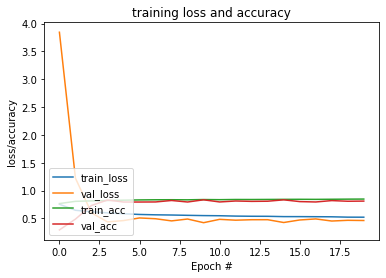

In [53]:
plt.figure()
plt.plot(H.history["loss"], label="train_loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot(H.history["accuracy"], label="train_acc")
plt.plot(H.history["val_accuracy"], label="val_acc")
plt.title("training loss and accuracy")
plt.xlabel("Epoch #")
plt.ylabel("loss/accuracy")
plt.legend(loc="lower left")
plt.show()

#### Further evaluate the model

In [55]:
#First, get labels of the test set
test_paths = list(paths.list_images(test_path))
testlabels = [int(p.split(os.path.sep)[-2]) for p in test_paths]
#turn them into categorical values so we can count them (one hot encoding)
testlabels = to_categorical(testlabels)

In [56]:
predictions = model.predict(testDS)

print(classification_report(testlabels.argmax(axis=1), predictions.argmax(axis=1), target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     41781
           1       0.00      0.00      0.00     13724

    accuracy                           0.75     55505
   macro avg       0.38      0.50      0.43     55505
weighted avg       0.57      0.75      0.65     55505



c:\Users\juana\.conda\envs\gpu-dl\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juana\.conda\envs\gpu-dl\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\juana\.conda\envs\gpu-dl\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [60]:
model = load_model("...tf_data\\cancer_model")

In [64]:
model.predict_classes(testDS)

c:\Users\juana\.conda\envs\gpu-dl\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[0],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

#### For one image

In [70]:
#All the predict functions in Keras expect batch of inputs. Therefore, since you are doing prediction on one single image, 
# you need to add an axis at the beginning of image tensor to represent the batch axis 
# (and since we used the tf.data() pipeline we have to pass the image through the same process):
image = "...cancer_data\\test\\1\\9041_idx5_x2851_y1951_class1.png"
image = tf.io.read_file(image)
image = tf.image.decode_jpeg(image, channels=3)
image = tf.image.resize(image, [48, 48])
image = tf.expand_dims(image, axis=0)   # the shape would be (1, 48, 48, 3)  
print(np.argmax(model.predict(image), axis=-1))

NotFoundError: NewRandomAccessFile failed to Create/Open: ...cancer_data\test\1\9041_idx5_x2851_y1951_class1.png : The system cannot find the path specified.
; No such process [Op:ReadFile]